In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing
import statsmodels.formula.api as smf
import datetime

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
# https://www.youtube.com/watch?v=EgIU1_qZ5Lc

In [103]:
df100 = pd.read_csv('tfrrs_scraped.csv')

### Feature Engineering

In [104]:
# add column where each time_secs is normalized by the mean for that event in all years for each sex and division
group = df100.groupby(['SEX', 'DIVISION', 'EVENT']).TIME_SECS

# divide each time in time_secs by the mean for it's group
df100['NORM_TIME'] = df100['TIME_SECS'] / group.transform('mean')

In [105]:
# TREATED - distance event dummy
distance_events = ['800', '1500', '3000S', '5000', '10000']

df100['DISTANCE'] = 0
df100.loc[df100['EVENT'].isin(distance_events), 'DISTANCE'] = 1

# AFTER INTERVENTION - 2021 or beyond
df100['AFTER2021'] = 0
df100.loc[df100['CHAMP_YEAR'] >= 2021, 'AFTER2021'] = 1

In [6]:
# function to convert seconds to time format
def convert_seconds(secs):
    '''Takes a total number of seconds and returns in %M:%S.%f format'''
    date = datetime.datetime.utcfromtimestamp(secs)
    output = datetime.datetime.strftime(date, "%M:%S.%f")
    return output

In [7]:
# handle a bit differently because men run 110H while women run 100H
men_running_events = ['100', '200', '400', '800', '1500', '5000', '10000',
       '110H', '400H', '3000S', '4x100', '4x400']
women_running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '400H', '3000S', '4x100', '4x400']

In [8]:
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [9]:
# summary stats for TIME_SECS running events
description = df100.groupby(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'])['TIME_SECS'].describe(percentiles = [.2, .4, .6, .8])
description.sort_values(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'], ascending=[True, False, True, True], inplace=True)

In [10]:
description.head()

count       mean        std      min  \
DIVISION CHAMP_YEAR EVENT SEX                                           
D1       2021       100   Men    100.0    10.3007   0.103546     9.94   
                          Women  100.0    11.4057   0.153223    10.96   
                    10000 Men    100.0  1739.4049  25.564443  1667.27   
                          Women  100.0  2059.3049  46.118777  1944.38   
                    100H  Women  100.0    13.2914   0.255632    12.53   

                                      20%       40%       50%       60%  \
DIVISION CHAMP_YEAR EVENT SEX                                             
D1       2021       100   Men      10.230    10.290    10.325    10.340   
                          Women    11.280    11.376    11.410    11.494   
                    10000 Men    1719.878  1735.724  1744.370  1748.282   
                          Women  2024.220  2048.108  2067.795  2082.240   
                    100H  Women    13.116    13.266    13.310    13.408   

                                      80%      max  
DIVISION CHAMP_YEAR EVENT SEX                       
D1       2021       100   Men      10.390    10.44  
                          Women    11.552    11.61  
                    10000 Men    1759.190  1776.67  
                          Women  2099.738  2127.53  
                    100H  Women    13.542    13.62

# Visualizations

In [11]:
# queried list of dfs, one for each year

def query_each_year(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = []
    for year in df.CHAMP_YEAR.unique():
        new_df = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
        results.append(new_df)
    return results

In [12]:
# use queried list of dfs for each year to create a histogram for each year

def histograms_each_year(df, division, sex, event):
    '''Creates a histogram for each df in df_list after query constraints'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        fig, ax = plt.subplots()
        plot = df.TIME_SECS.plot(kind='hist', bins=15, ax=ax)
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.gcf().set_size_inches(8,5)
        pl.suptitle(str(df.CHAMP_YEAR.iloc[0]) + ' ' + df.SEX.iloc[0] + '\'s ' + df.EVENT.iloc[0])

### Example: lets make histograms for D1 men's 1500

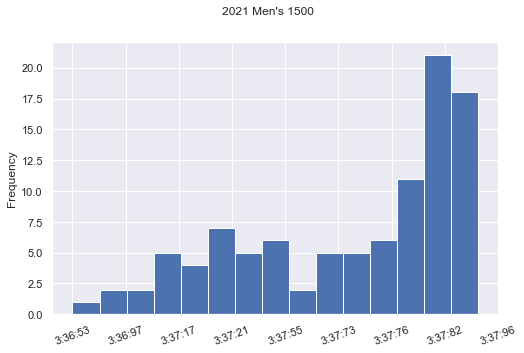

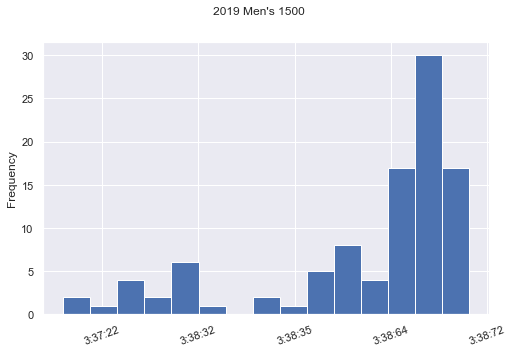

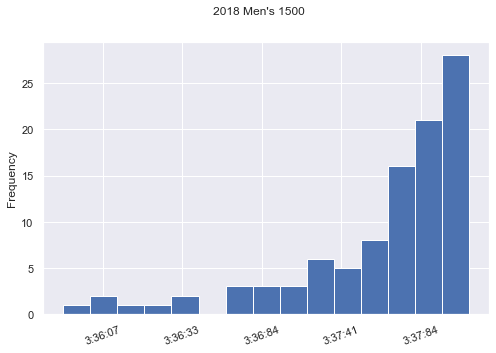

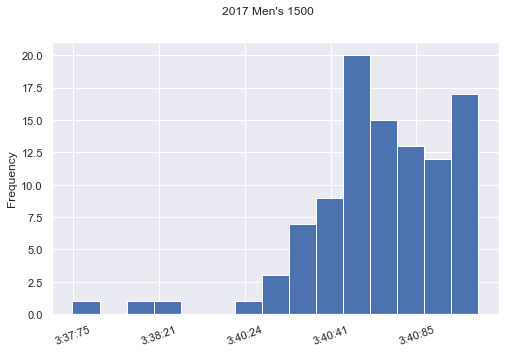

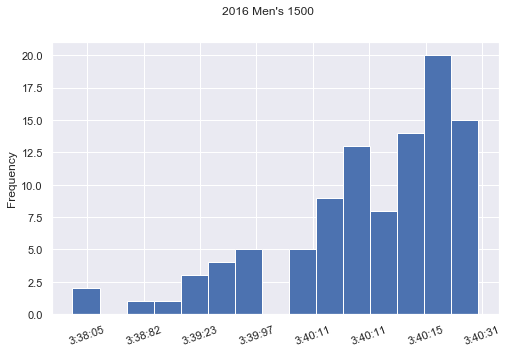

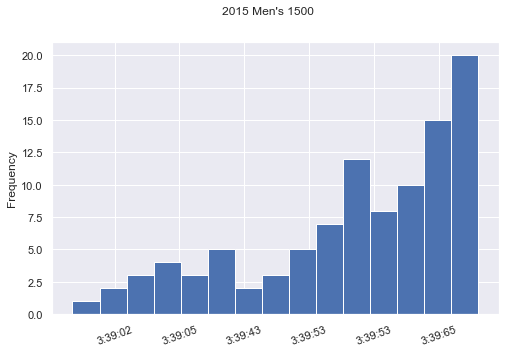

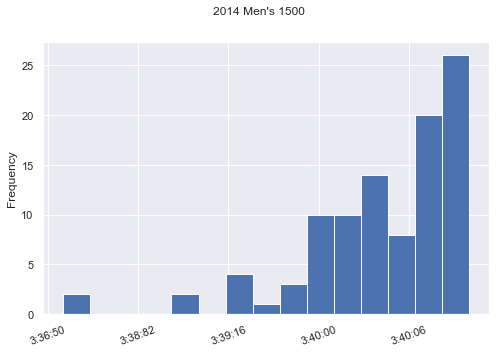

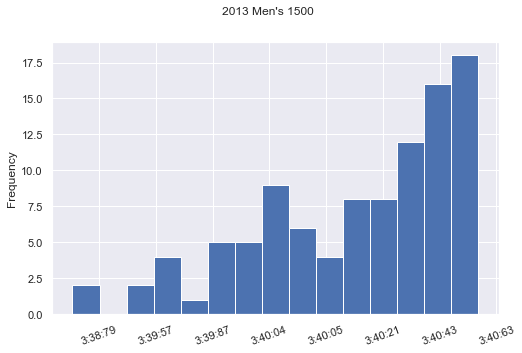

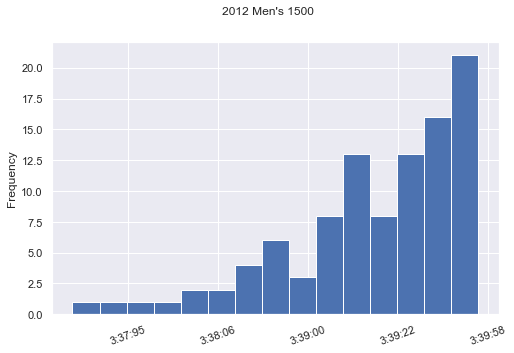

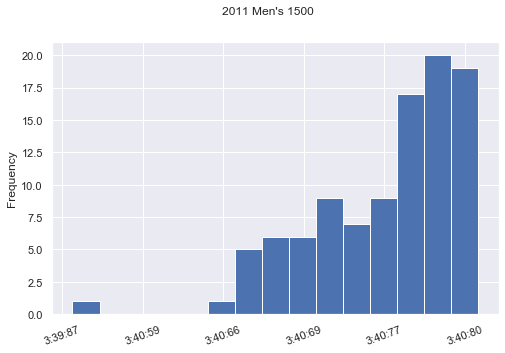

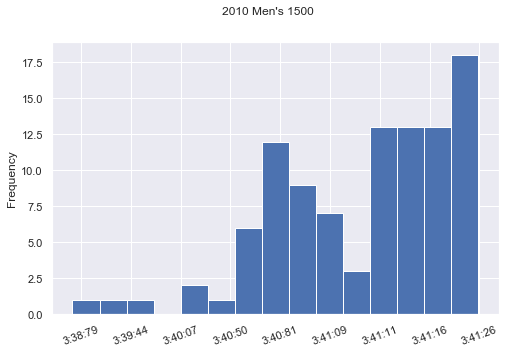

In [13]:
histograms_each_year(df100, 'D1', 'Men', '1500')

In [14]:
def hist_density_overlap(df, division, sex, event):
    '''Creates an overlapping histogram and density for each df in queried list of dfs for each year'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        plot = sns.distplot(df.TIME_SECS, kde=True, bins=15, hist=True, label=df.CHAMP_YEAR.iloc[0])
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.legend()
        plt.gcf().set_size_inches(20,12)
        pl.suptitle(division + ' ' + sex + '\'s ' + event)

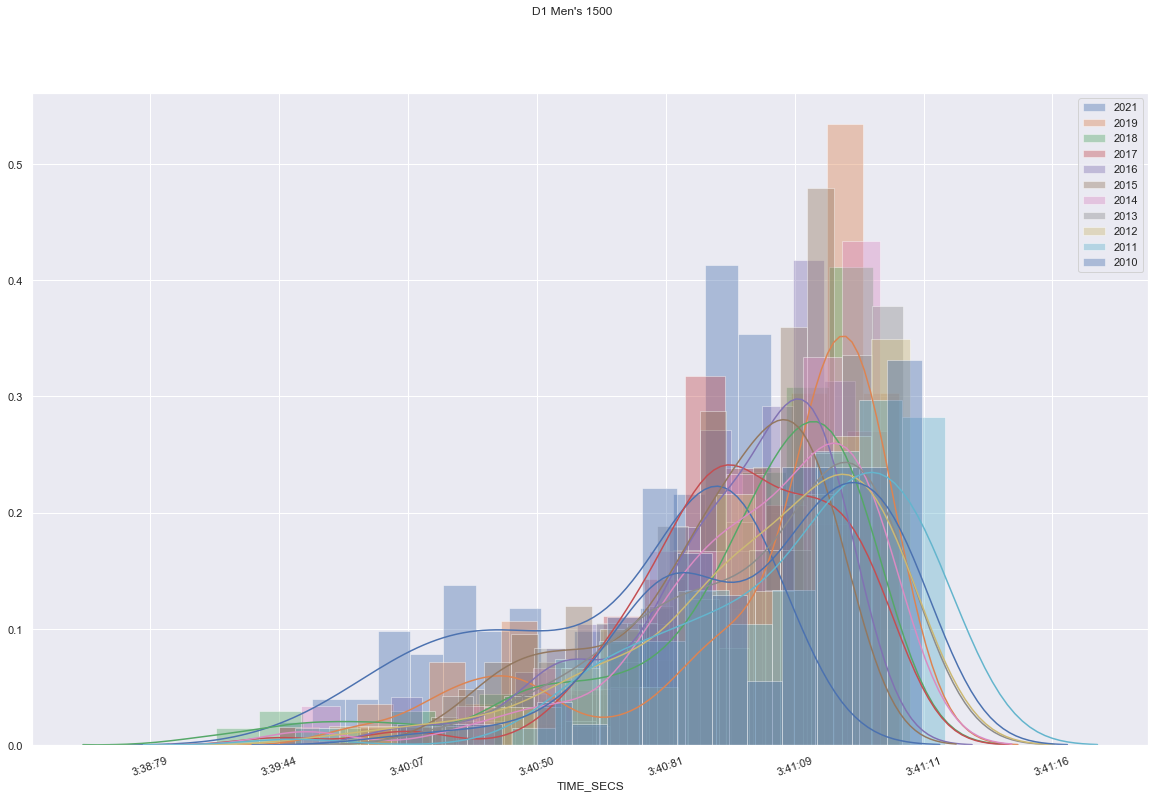

In [15]:
hist_density_overlap(df100, 'D1', 'Men', '1500')

### Take a look at combined distribution across all years for each event division and sex

In [16]:
# queried df, all years, for specified division sex event and 

def query_all_years(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = df[(df['CHAMP_YEAR'] != 2021) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
    return results

In [17]:
# histogram for results for given division, sex, event and all years

def histogram_all_years(df, division, sex, event):
    '''Takes a queried dataframe and combines all TIME_SECS for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.TIME_SECS.plot(kind='hist', bins=15, grid=True, ax=ax)
    plot = plot.set_xticklabels(df_graph['TIME'], rotation=20)
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

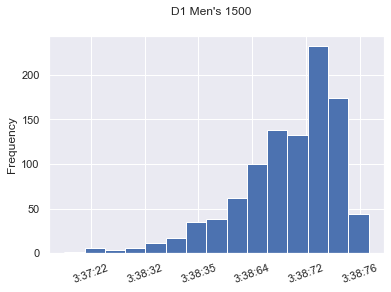

In [18]:
histogram_all_years(df100, 'D1', 'Men', '1500')

### Function that creates a dataframe with 
### min, average, median, max, std, and quintiles for TIME_SECS for each event across ALL years, division, sex, event

In [19]:
def events_desc(df, division, sex):
    '''Returns a dataframe with summary stats for TIME_SECS for each event for all years given division and sex'''
    series_list = []
    for event in df.EVENT.unique():
        df_desc = df[(df['DIVISION'] == division) & (df100['SEX'] == sex) & (df100['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])
        series_list.append(df_desc)
    result = pd.DataFrame(series_list, index=df100.EVENT.unique())
    return result

In [20]:
D2women_desc = events_desc(df100, 'D3', 'Women')
D2women_desc.head()

,count,mean,std,min,20%,40%,50%,60%,80%,max
100,1100.0,12.291618,0.197822,11.41,12.130,12.270,12.330,12.370,12.450,12.70
200,1100.0,25.233245,0.419045,23.29,24.870,25.196,25.315,25.410,25.560,26.04
400,1100.0,57.512009,1.031197,53.18,56.618,57.420,57.680,57.960,58.400,59.59
800,1100.0,134.664218,2.601018,122.34,132.396,134.456,135.240,135.830,136.820,140.47
1500,1100.0,278.481236,5.298277,255.77,273.908,277.726,279.165,280.544,283.074,290.32


### Lets look at descriptive statistics for TIME_SECS and do some statistical hypothesis testing. 

In [21]:
event_means = df100.groupby(['CHAMP_YEAR', 'DIVISION', 'SEX', 'EVENT']).TIME_SECS.mean()
event_means.head()

CHAMP_YEAR  DIVISION  SEX  EVENT
2010        D1        Men  100        10.3757
                           10000    1758.4778
                           110H       13.9928
                           1500      223.6396
                           200        20.8692
Name: TIME_SECS, dtype: float64

In [22]:
# mean for event in 2021
def mean_event_2021(division, sex, event):
    '''Returns the averagze TIME_SECS for given division sex and event in year 2021'''
    return df100_2021[(df100_2021['DIVISION'] == division) & (df100_2021['SEX'] == sex) & (df100_2021['EVENT'] == event)].TIME_SECS.mean()

In [23]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

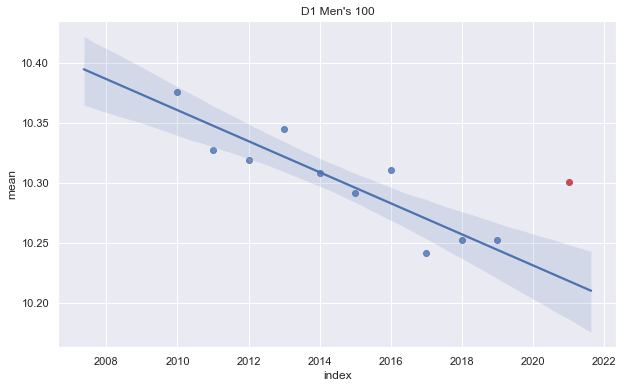

In [24]:
df_descD1men1500 = event_desc_each_year(df100_not2021, 'D1', 'Men', '100')

### Take a look at every event for a given division and sex.

In [25]:
def regplots(division, sex):
    '''Create a regplot for 2019 mean times in blue and 2021 mean in red for given division and sex'''
    for event in df100.EVENT.unique():
        if sex == 'Men':
            if event in men_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)
        else: 
            if event in women_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)

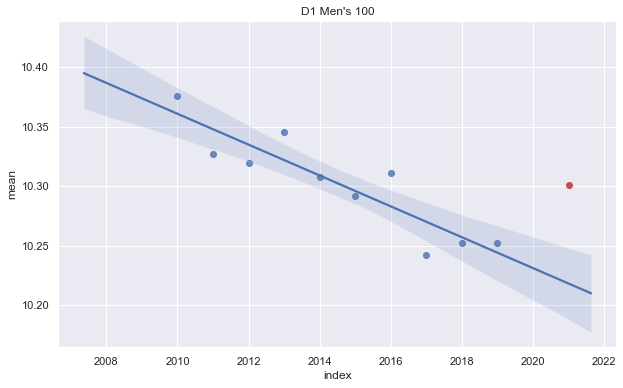

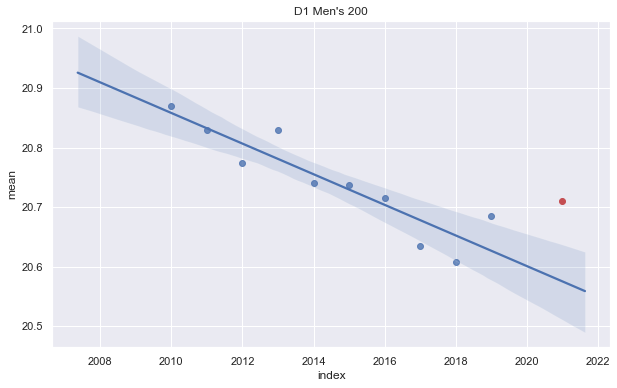

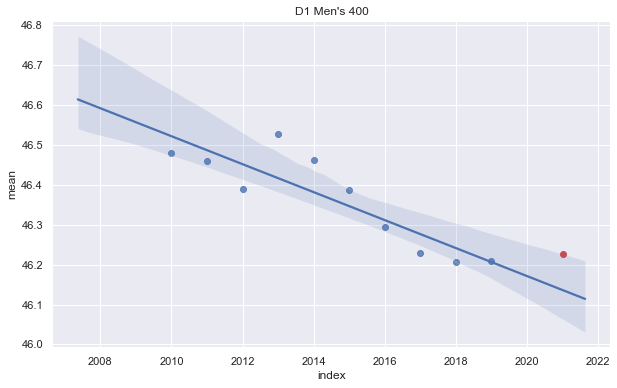

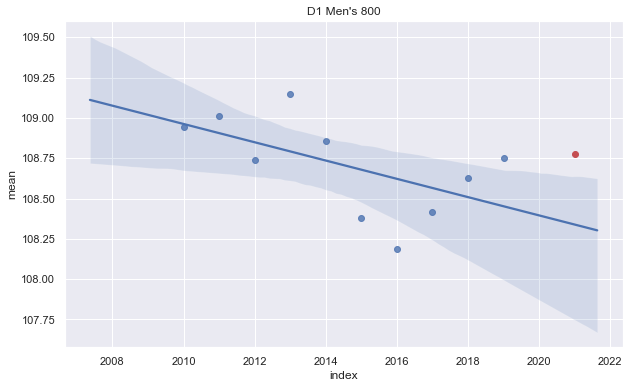

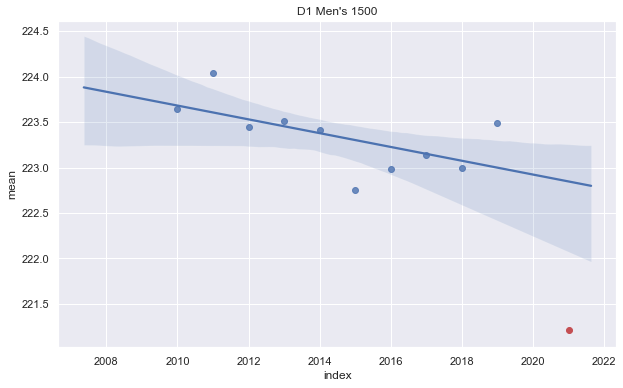

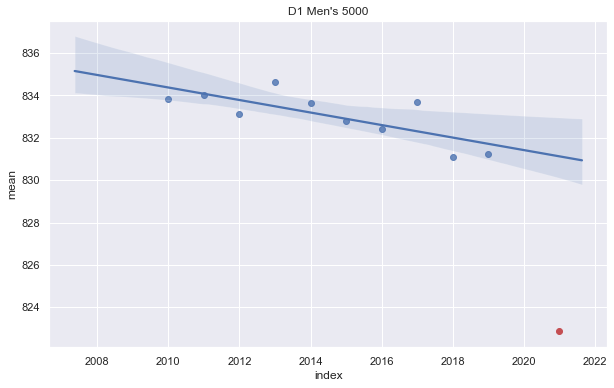

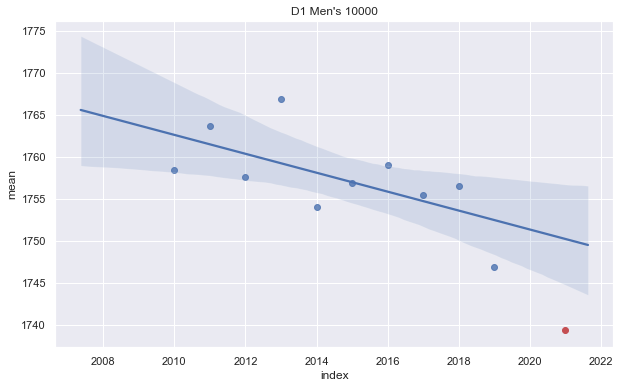

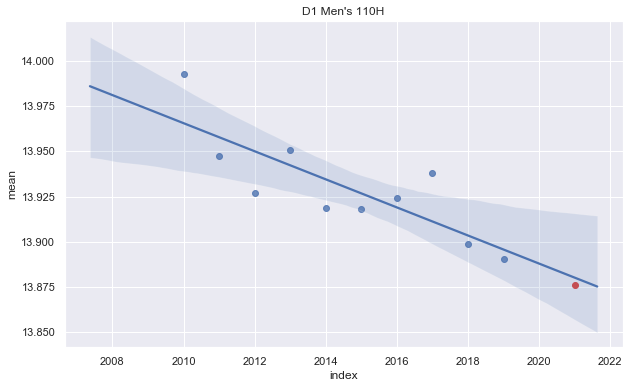

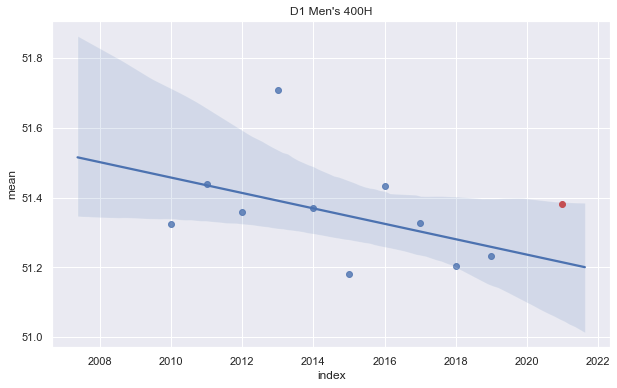

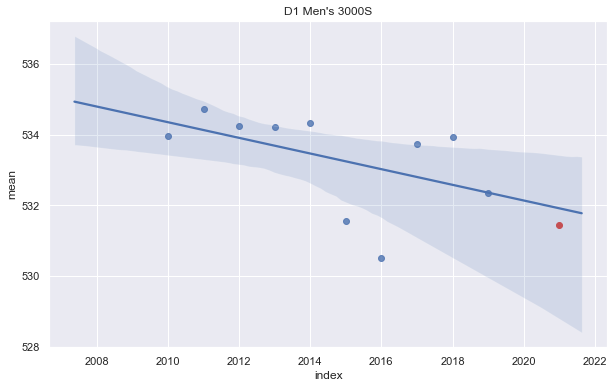

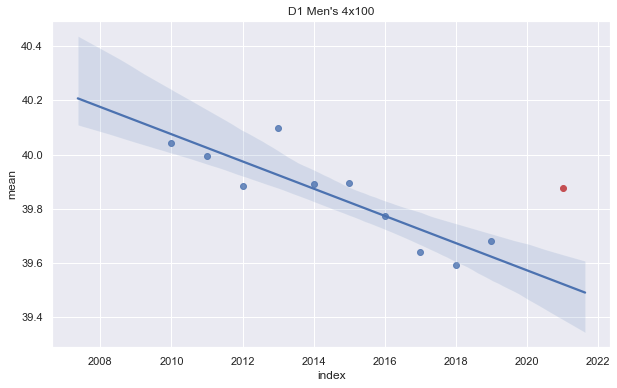

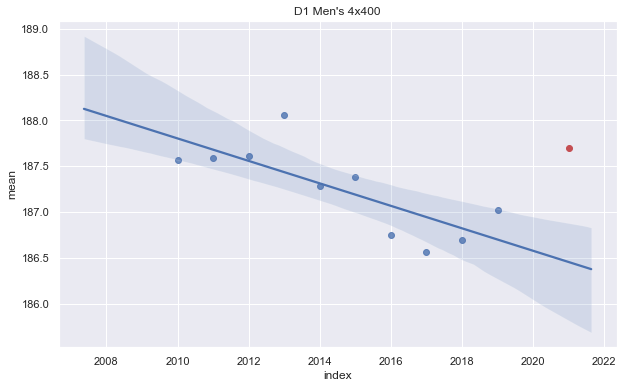

In [26]:
results = regplots('D1', 'Men')

In [27]:
# histogram for results for given division, sex, event and all years

def histogram_all_years_NORM(df, division, sex, event):
    '''Takes a queried dataframe and combines all NORM_TIME for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.NORM_TIME.plot(kind='hist', bins=15, grid=True, ax=ax)
    plt.xlabel('TIME_SECS / MEAN')
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

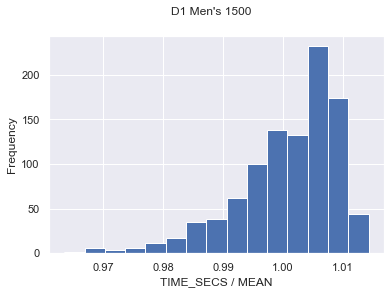

In [28]:
histogram_all_years_NORM(df100, 'D1', 'Men', '1500')

In [29]:
# split off 2021 out into a separate dfs
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [30]:
df100_2021.head()

,POSITION,CHAMP_YEAR,DIVISION,EVENT,SEX,ATHLETE,YEAR,TEAM,TIME,TIME_SECS,MARK,CONV,POINTS,MEET,MEET DATE,SUPER_SHOE,NORM_TIME
0,1,2021,D1,100,Men,"Martin, JoVaughn",SO-2,Florida State,9:94,9.94,NaN,NaN,NaN,UF Tom Jones Invitational,"Apr 16, 2021",0,0.964832
1,2,2021,D1,100,Men,"Amoah, Joseph",SR-4,Coppin State,10:00,10.00,NaN,NaN,NaN,2021 Aggie Invitational,"Apr 10, 2021",0,0.970656
2,3,2021,D1,100,Men,"Williams, Micah",FR-1,Oregon,10:03,10.03,NaN,NaN,NaN,2021 Desert Heat Classic,"May 1, 2021",0,0.973568
3,4,2021,D1,100,Men,"Laird, Terrance",JR-3,LSU,10:06,10.06,NaN,NaN,NaN,LSU Boots Garland Invitational,"Apr 17, 2021",0,0.976480
4,5,2021,D1,100,Men,"Jewell, Zachary",SR-4,Central Arkansas,10:07,10.07,NaN,NaN,NaN,John McDonnell Invitational,"Apr 23, 2021",0,0.977451


In [31]:
df100_not2021.CHAMP_YEAR.unique()

array([2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010])

In [32]:
means = [(year, df100_not2021[(df100_not2021['CHAMP_YEAR'] == year) & (df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()) for year in df100_not2021.CHAMP_YEAR.unique()]

In [33]:
means

[(2019, 1.0015233356095907),
 (2018, 0.9993364331833265),
 (2017, 0.9999378313505488),
 (2016, 0.999261146378488),
 (2015, 0.9982160938256095),
 (2014, 1.001191715159706),
 (2013, 1.0016223736088126),
 (2012, 1.001355732841676),
 (2011, 1.0040181072913545),
 (2010, 1.002208983296513)]

In [ ]:
mean_2021 = df100_not2021[(df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()

In [ ]:
plot = plt.scatter(*zip(*means))
plot = plt.scatter(x=2021, y=mean_2021, color='r')

### DUMMIES for fixed effects

In [129]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

In [130]:
# concat dummy dfs to right side of df100
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

In [179]:
dftest = df100[(df100['DIVISION'] == 'D1') & (df100['SEX'] == 'Men') & (df100['EVENT'] == '1500')]

### Specify Model

In [180]:
dftest.columns

Index([  'POSITION', 'CHAMP_YEAR',   'DIVISION',      'EVENT',        'SEX',
          'ATHLETE',       'YEAR',       'TEAM',       'TIME',  'TIME_SECS',
             'MARK',       'CONV',     'POINTS',       'MEET',  'MEET DATE',
        'NORM_TIME',   'DISTANCE',  'AFTER2021',         2010,         2011,
               2012,         2013,         2014,         2015,         2016,
               2017,         2018,         2019,         2021,         'D1',
               'D2',         'D3',        '100',      '10000',       '100H',
             '110H',       '1500',        '200',      '3000S',        '400',
             '400H',      '4x100',      '4x400',       '5000',        '800',
               'DT',        'Dec',         'HJ',         'HT',        'Hep',
               'JT',         'LJ',         'PV',         'SP',         'TJ',
              'Men',      'Women'],
      dtype='object')

In [183]:
model = 'NORM_TIME ~ DISTANCE + AFTER2021 + DISTANCE * AFTER2021 + CHAMP_YEAR + DIVISION + SEX'

In [184]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=dftest)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': dftest['CHAMP_YEAR']},use_t=True)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              NORM_TIME   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     538.9
Date:                Wed, 12 May 2021   Prob (F-statistic):           6.57e-11
Time:                        20:17:39   Log-Likelihood:                 3686.0
No. Observations:                1100   AIC:                            -7366.
Df Residuals:                    1097   BIC:                            -7351.
Df Model:                           2                                         
Covariance Type:              cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8428      0

C:\Users\Adam\Anaconda3\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
